# Madelon Classification using MRep-DeepInsight

This example parallels the analysis done in the publication
[Enhanced analysis of tabular data through Multi-representation DeepInsight][1]
for the [UCI Madelon][2] dataset constucted for the NIPS 2003 challenge.

[1]: https://doi.org/10.1038/s41598-024-63630-7
[2]: https://archive.ics.uci.edu/dataset/171/madelon

## Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.manifold import TSNE
from umap import UMAP

In [3]:
import torch
from torch import nn, optim
torch.set_float32_matmul_precision('medium')

import datasets
import timm
import cv2

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import optuna

In [4]:
from pyDeepInsight import MRepImageTransformer
from pyDeepInsight.utils import step_blur, imgaborfilt

In [5]:
torch.cuda.is_available(), torch.__version__, torch.version.cuda

(True, '2.3.0.post301', '11.8')

## Set Global Variables

In [6]:
num_workers=32
pin_memory=False
persistent_workers=True
work_path = './data'

## Datasets

Download the Madelon dataset from HuggingFace datasets. As only a train and validation set exists, the train will be split into test/validation and the validation set will be used as the test set.

In [7]:
trainval_df = pd.DataFrame(datasets.load_dataset("mstz/madelon", split="train"))
train_df, val_df = train_test_split(trainval_df, test_size=600, random_state=452, stratify=trainval_df.iloc[:,-1])
test_df = pd.DataFrame(datasets.load_dataset("mstz/madelon", split="validation"))
train_df.shape, val_df.shape, test_df.shape

((1400, 501), (600, 501), (600, 501))

In [8]:
n2s = MinMaxScaler()
# extract and normalize the data
train_x = train_df.iloc[:,:-1].values
train_x = n2s.fit_transform(train_x)
train_y = train_df.iloc[:,-1].values

val_x = val_df.iloc[:,:-1].values
val_x = n2s.transform(val_x)
val_y = val_df.iloc[:,-1].values

test_x = test_df.iloc[:,:-1].values
test_x = n2s.transform(test_x)
test_y = test_df.iloc[:,-1].values

## Image Transformation and Augmentation Filters 
First generate the manifold transformations, then apply the augmentations. 
In the paper, a t-SNE, using hamming distance, and a UMAP manifold were applied.

After image transformation, two filters were applied idenpendently to each transformation 
resulting in a total of 6 representations per sample: 1) t-SNE, 2) UMAP, 3) t-SNE with
blurring, 4) UMAP with blurring, 5) t-SNE with Gabor, and 6) UMAP with Gabor.

In [9]:
# Functions to convert between torch image format (N, C, H, W) and PIL image format (N, H, W, C)

def pil_to_tensor(img):
    return torch.from_numpy(img.transpose(0, 3, 1, 2))

def tensor_to_pil(img):
    return img.detach().cpu().permute(0, 2, 3, 1).numpy()

### Image Transformation

In [10]:
manifolds = [
    TSNE(n_components=2, metric='hamming'),
    UMAP()
]
mit = MRepImageTransformer(feature_extractor=manifolds)

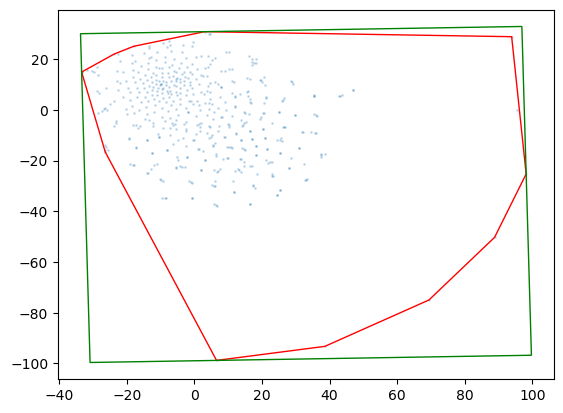

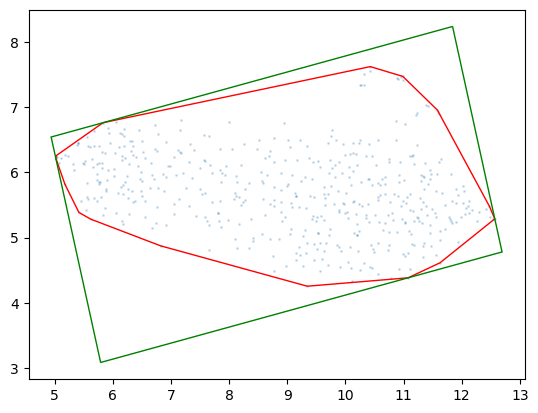

In [11]:
_ = mit.fit(train_x, plot=True)

In [12]:
train_raw_img, train_sample_idx = mit.transform(train_x, return_index=True)
val_raw_img, val_sample_idx = mit.transform(val_x, return_index=True)
test_raw_img, test_sample_idx = mit.transform(test_x, return_index=True)

### Augmentation Filters

#### Gabor Filter

A Gabor filter similar to [MATLAB imgaborfilt](https://www.mathworks.com/help/images/ref/imgaborfilt.html)

In [13]:
def gabor_filter_batch(img):
    gb_img = np.stack([imgaborfilt(i, 2, 0)[0] for i in img])
    return cv2.normalize(gb_img, None, alpha=0., beta=1., norm_type=cv2.NORM_MINMAX)

In [14]:
train_gabor_img = gabor_filter_batch(train_raw_img)
val_gabor_img = gabor_filter_batch(val_raw_img)
test_gabor_img = gabor_filter_batch(test_raw_img)

### Blur filter

A blur filter based on the algorithm described in [A novel deep learning approach using blurring image techniques for Bluetooth-based indoor localisation][1].

[1]: https://doi.org/10.1016/j.inffus.2022.10.011


In [15]:
def step_blur_batch(img, kernel_size=11):
    return np.stack([step_blur(i, kernel_size) for i in img])

In [16]:
train_blur_img = step_blur_batch(train_raw_img)
val_blur_img = step_blur_batch(val_raw_img)
test_blur_img = step_blur_batch(test_raw_img)

## Filter Visualization

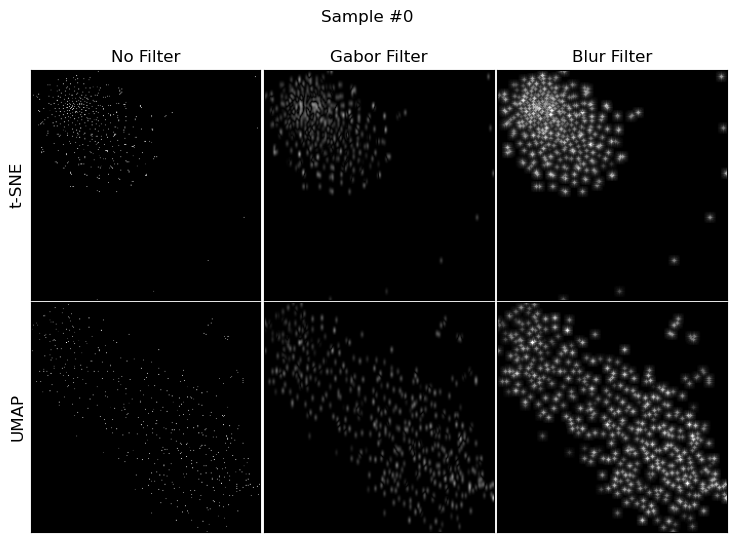

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(9,6))
fig.suptitle(f'Sample #0')
ax[0,0].set_ylabel('t-SNE', size='large')
ax[0,0].set_title('No Filter')
ax[0,0].imshow(train_raw_img[0])
ax[0,1].set_title('Gabor Filter')
ax[0,1].imshow(train_gabor_img[0])
ax[0,2].set_title('Blur Filter')
ax[0,2].imshow(train_blur_img[0])
ax[1,0].set_ylabel('UMAP', size='large')
ax[1,0].imshow(train_raw_img[1400])
ax[1,1].imshow(train_gabor_img[1400])
ax[1,2].imshow(train_blur_img[1400])
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.subplots_adjust(wspace=0.01, hspace=0.01)

## Data Preparation

In [18]:
train_raw_input = pil_to_tensor(train_raw_img)
train_gabor_input = pil_to_tensor(train_gabor_img)
train_blur_input = pil_to_tensor(train_blur_img)
train_input = torch.concat([train_raw_input, train_gabor_input, train_blur_input]).to(torch.float32)
train_target_idx = np.tile(train_sample_idx, 3)
train_target = torch.tensor(train_y[train_target_idx], dtype=torch.float32)

In [19]:
val_raw_input = pil_to_tensor(val_raw_img)
val_gabor_input = pil_to_tensor(val_gabor_img)
val_blur_input = pil_to_tensor(val_blur_img)
val_input = torch.concat([val_raw_input, val_gabor_input, val_blur_input]).to(torch.float32)
val_target_idx = np.tile(val_sample_idx, 3)
val_target = torch.tensor(val_y[val_target_idx], dtype=torch.float32)

In [20]:
test_raw_input = pil_to_tensor(test_raw_img)
test_gabor_input = pil_to_tensor(test_gabor_img)
test_blur_input = pil_to_tensor(test_blur_img)
test_input = torch.concat([test_raw_input, test_gabor_input, test_blur_input]).to(torch.float32)
test_target_idx = np.tile(test_sample_idx, 3)
test_target = torch.tensor(test_y[test_target_idx], dtype=torch.float32)

## Training - Optimization

### Lightning Module

A simple PyTorch Lightning module class to simplify training and access 
Lightning methods such as early stopping and automatic best model
callback.

In [21]:
class LitResNet(L.LightningModule):

    def __init__(self, net, optimizer):
        super().__init__()
        self.net = net
        self.optimizer = optimizer
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, X):
        return self.net(X)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.net(X)
        loss = self.criterion(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.net(X)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.net(X)
        return y_hat

### Optuna Objective

Define an objective function for optuna. The four hyperparameters
optimized are batch size, learning rate, momentum and weight decay.
Early stopping is implemented to reduce training time.

In [22]:
def optobj(trial, train_dataset, val_dataset):

    min_epochs = 10
    max_epochs = 50
    patience_max = 5

    batch_size = trial.suggest_int("batch_size", 16, 256, step=16)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    momentum = trial.suggest_float("momentum", 0.8, 0.95)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-2, log=True)

    model = timm.create_model('resnet50', pretrained=True, num_classes=1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    litmodel = LitResNet(model, optimizer)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               num_workers=num_workers, pin_memory=pin_memory,
                                               persistent_workers=persistent_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                             num_workers=num_workers, pin_memory=pin_memory, 
                                             persistent_workers=persistent_workers)

    cpcb = ModelCheckpoint(
        monitor='val_loss', 
        mode='min',
        dirpath=work_path,
        filename=f"{trial.study.study_name}_trial{trial.number:02d}_e{{epoch:02d}}",
        every_n_epochs=1,
        save_top_k=1,
        auto_insert_metric_name=False,
    )
    escb = EarlyStopping(monitor="val_loss", mode="min", patience=patience_max, check_on_train_epoch_end=False)
    trainer = L.Trainer(
        min_epochs=min_epochs,
        max_epochs=max_epochs,
        accelerator="gpu",
        num_sanity_val_steps=0,
        callbacks=[escb, cpcb],     
        enable_checkpointing=True,
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=False
    )
    trainer.fit(model=litmodel, train_dataloaders=train_loader, val_dataloaders=val_loader)

    trial.set_user_attr("best_model_path", cpcb.best_model_path)
    return cpcb.best_model_score
    

### Run Optimization

Default warning and logging messages are filtered to reduce 
output during run.

In [23]:
n_trials = 25
storage_name = f"sqlite:///{work_path}/saved_studies.db"
study_name = f"Medelon_Example"

import warnings
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Checkpoint directory")
    warnings.filterwarnings("ignore", message="Applied workaround for CuDNN issue")
    study = optuna.create_study(direction="minimize",
                                study_name=study_name,
                                storage=storage_name)
    
    train_dataset = torch.utils.data.TensorDataset(train_input, train_target[:, None])
    val_dataset = torch.utils.data.TensorDataset(val_input, val_target[:, None])
    objective_ds = lambda trial: optobj(trial, train_dataset, val_dataset)
    study.optimize(objective_ds, n_trials=n_trials, gc_after_trial=True)

[I 2024-08-21 00:19:08,877] A new study created in RDB with name: Medelon_Example
[I 2024-08-21 00:22:26,204] Trial 0 finished with value: 0.6918920278549194 and parameters: {'batch_size': 16, 'lr': 0.0006310268345248904, 'momentum': 0.8135201709890142, 'weight_decay': 0.0002463873146422607}. Best is trial 0 with value: 0.6918920278549194.
[I 2024-08-21 00:28:02,961] Trial 1 finished with value: 0.5612269639968872 and parameters: {'batch_size': 48, 'lr': 0.047735485115907555, 'momentum': 0.8270178238231242, 'weight_decay': 6.28885691344959e-09}. Best is trial 1 with value: 0.5612269639968872.
[I 2024-08-21 00:37:09,821] Trial 2 finished with value: 0.6929000020027161 and parameters: {'batch_size': 80, 'lr': 1.6301851274712158e-05, 'momentum': 0.8743385782101614, 'weight_decay': 5.048416291432075e-05}. Best is trial 1 with value: 0.5612269639968872.
[I 2024-08-21 00:49:10,213] Trial 3 finished with value: 0.6896007061004639 and parameters: {'batch_size': 160, 'lr': 0.0004272444772558870

## Final Test

These could have been executed and saved during Optuna optimization but are done here to show how to manually load a best model and use it.

In [24]:
# Initialize simple trainer for prediciton
ftrainer = L.Trainer(
    accelerator="gpu",
    enable_checkpointing=True,
    enable_progress_bar=True,
    enable_model_summary=False,
    logger=False
)

# Load best model from best trial
hp = study.best_trial.params
fmodel =  model = timm.create_model('resnet50', pretrained=True, num_classes=1)
foptimizer = optim.SGD(model.parameters(), lr=hp['lr'], momentum=hp['momentum'], weight_decay=hp['weight_decay'])
flitmodel = LitResNet(fmodel, foptimizer)
best_model_path = study.best_trial.user_attrs['best_model_path']

# Create final data loaders
train_dataset = torch.utils.data.TensorDataset(train_input.to(torch.float32), train_target[:, None])
final_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False,
                                                 num_workers=num_workers, pin_memory=pin_memory, 
                                                 persistent_workers=persistent_workers)

val_dataset = torch.utils.data.TensorDataset(val_input.to(torch.float32), val_target[:, None])
final_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False,
                                               num_workers=num_workers, pin_memory=pin_memory, 
                                               persistent_workers=persistent_workers)

test_dataset = torch.utils.data.TensorDataset(test_input.to(torch.float32), test_target[:, None])
final_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False,
                                               num_workers=num_workers, pin_memory=pin_memory, 
                                               persistent_workers=persistent_workers)

# Generate predictions
train_pred = torch.vstack(ftrainer.predict(flitmodel, dataloaders=final_train_loader, ckpt_path=best_model_path))
val_pred = torch.vstack(ftrainer.predict(flitmodel, dataloaders=final_val_loader, ckpt_path=best_model_path))
test_pred = torch.vstack(ftrainer.predict(flitmodel, dataloaders=final_test_loader, ckpt_path=best_model_path))

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

### Representation Accuracy

Calculate the accuracy of representations independently. 


In [25]:
train_rep_acc = metrics.accuracy_score(train_target[:, None], train_pred.sigmoid() > 0.5)
val_rep_acc = metrics.accuracy_score(val_target[:, None], val_pred.sigmoid() > 0.5)
test_rep_acc = metrics.accuracy_score(test_target[:, None], test_pred.sigmoid() > 0.5)

print(f"Training Set Representation Accuracy:   {train_rep_acc*100:.1f}%\n" +
      f"Validation Set Representation Accuracy: {val_rep_acc*100:.1f}%\n" +
      f"Testing Set Representation Accuracy:    {test_rep_acc*100:.1f}%")

Training Set Representation Accuracy:   77.8%
Validation Set Representation Accuracy: 72.5%
Testing Set Representation Accuracy:    73.2%


### Sample Accuracy

To calculate the prediction for each sample, we can take the mean prediction 
of each of its representations. MRepImageTransformer provides a method to 
calculate this value.

In [26]:
train_pred_reduced = mit.prediction_reduction(train_pred.numpy(), train_target_idx)
val_pred_reduced = mit.prediction_reduction(val_pred.numpy(), val_target_idx)
test_pred_reduced = mit.prediction_reduction(test_pred.numpy(), test_target_idx)

In [27]:
train_sample_acc = metrics.accuracy_score(train_y, train_pred_reduced > 0.5)
val_sample_acc = metrics.accuracy_score(val_y, val_pred_reduced > 0.5)
test_sample_acc = metrics.accuracy_score(test_y, test_pred_reduced > 0.5)

print(f"Training Set Sample Accuracy:   {train_sample_acc*100:.1f}%\n" +
      f"Validation Set Sample Accuracy: {val_sample_acc*100:.1f}%\n" +
      f"Testing Set Sample Accuracy:    {test_sample_acc*100:.1f}%")

Training Set Sample Accuracy:   90.4%
Validation Set Sample Accuracy: 84.8%
Testing Set Sample Accuracy:    88.0%
